In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report as cr, confusion_matrix as cf
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import randint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
import optuna
import joblib
from tensorflow.keras.models import load_model
from IPython.display import display
from scikeras.wrappers import KerasClassifier 

/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Job Sponsorship Classification: Model Training & Prediction** ##

This project aims to develop a machine learning model to predict whether a job posting offers visa sponsorship based on its description. The process involves loading the processed dataset, extracting features using TF-IDF and n-grams, and training classification models such as Logistic Regression and Random Forest. Model performance will be evaluated using accuracy, precision, recall, and F1-score. Finally, the trained model will be used to predict sponsorship availability for new job descriptions, providing a practical tool for job seekers.

In [2]:
df = pd.read_csv("data/processed_job_data.csv")

In [3]:
def display_results(y_scores, y_test, y_pred):
    classification_report_df = pd.DataFrame(cr(y_test, y_pred, output_dict=True)).transpose()
    classification_report_df.index.name = "Category"
    classification_report_df = classification_report_df.rename(
        columns={'precision': 'Precision', 'recall': 'Recall', 'f1-score': 'F1-Score', 'support': 'Support'},
        index={'0': 'No Sponsorship', '1': 'Sponsorship Provided', '2': 'Uncertain'}
    )

    confusion_matrix_df = pd.DataFrame(cf(y_test, y_pred),
                                       index=['No Sponsorship', 'Sponsorship Provided', 'Uncertain'],
                                       columns=['No Sponsorship', 'Sponsorship Provided', 'Uncertain'])

    # Adjust figure size and layout
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [1.2, 1.8, 2.0]})

    # Confusion Matrix
    sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Actual', fontsize=10)
    axes[0].set_xlabel('Predicted', fontsize=10)

    # Classification Report Table
    axes[1].axis('off')
    table = axes[1].table(cellText=classification_report_df.round(2).values,
                           colLabels=classification_report_df.columns,
                           rowLabels=classification_report_df.index,
                           cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.8)
    axes[1].set_title('Classification Report', fontsize=12, fontweight='bold')

    # ROC Curve
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

    for i, class_label in enumerate([0, 1, 2]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        axes[2].plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

    axes[2].set_title('ROC Curve', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('True Positive Rate', fontsize=10)
    axes[2].set_xlabel('False Positive Rate', fontsize=10)
    axes[2].legend(loc='lower right', fontsize=9)

    plt.tight_layout()
    plt.show()

In [4]:
vectorizer = TfidfVectorizer( ngram_range=(1, 5))
X = vectorizer.fit_transform(df['processed_description'])
chi2_scores, _ = chi2(X, df['sponsorship_encoded'])
feature_names = vectorizer.get_feature_names_out()
selected_features = [feature_names[i] for i in chi2_scores.argsort()[-20:]]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, df['sponsorship_encoded'], test_size=0.2, random_state=42, stratify=df['sponsorship_encoded'])

In [6]:
log_reg_model = LogisticRegression()
log_reg_model.fit(x_train, y_train)
log_reg_model_y_pred = log_reg_model.predict(x_test)
log_reg_model_y_scores = log_reg_model.predict_proba(x_test)

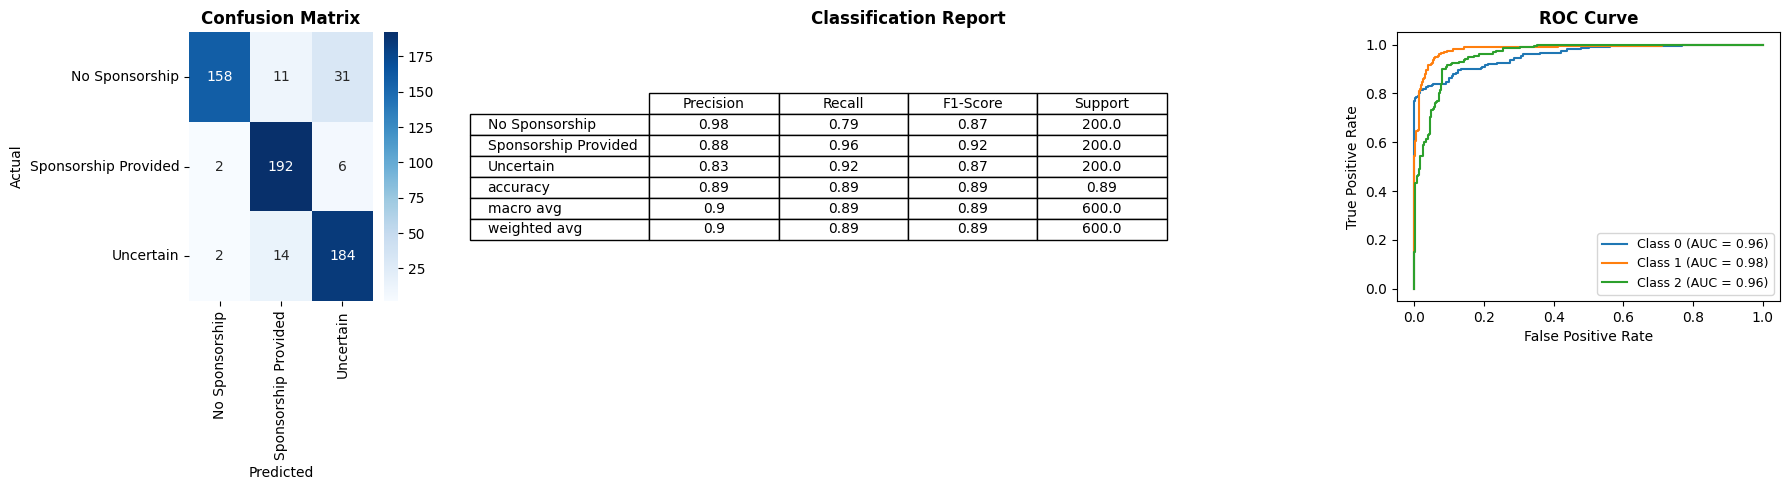

In [7]:
display_results(log_reg_model_y_scores, y_test, log_reg_model_y_pred)

The classification report and confusion matrix highlight the model’s strengths and areas for improvement in categorizing job sponsorship status.

Precision is highest for "No Sponsorship" (0.98), meaning the model is highly confident when making this prediction. However, recall is lower (0.79), indicating that many jobs without sponsorship are misclassified, mainly as "Uncertain", as seen in the confusion matrix. Conversely, "Sponsorship Provided" has excellent recall (0.96), ensuring most sponsored jobs are correctly identified. The F1-score remains strong across categories (0.87–0.92), but precision-recall imbalances suggest misclassification issues.

From the confusion matrix, "No Sponsorship" jobs are often mistaken as "Uncertain" (31 instances), likely due to ambiguous language. Similarly, some "Uncertain" cases are misclassified as "Sponsorship Provided" (14 instances), indicating potential confusion with sponsorship-related keywords.

To improve accuracy, threshold tuning could balance precision and recall, and class balancing techniques may help with misclassifications. While the model performs well, better handling of ambiguity could enhance its reliability.

At first, the hyperparameters of the model will be fine tuned using RandomizedSearchCV. RandomizedSearchCV selects random combinations. In this way, the best combination of parameters, namely the regularization strength (C), penalty type (l1 or l2) and solver selection, will be found to enhance the model's predictive accuracy and overall performance.

In [8]:
log_reg_model = LogisticRegression(max_iter=2000, solver='liblinear')
log_reg_model_param_grid = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2], 'penalty':['l1', 'l2']}

log_reg_model_random_search = RandomizedSearchCV(log_reg_model, log_reg_model_param_grid, n_iter=2000, cv=5, scoring='accuracy', random_state=42)
log_reg_model_random_search.fit(x_train, y_train)

# Best parameters
print("Best Parameters:", log_reg_model_random_search.best_params_)
print("Best Score:", log_reg_model_random_search.best_score_)

/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=2000. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'penalty': 'l1', 'C': 100.0}
Best Score: 0.9579166666666667


In [9]:
log_reg_model = LogisticRegression(max_iter=2000, solver="liblinear", C=log_reg_model_random_search.best_params_['C'], penalty=log_reg_model_random_search.best_params_['penalty'], class_weight='balanced')
log_reg_model.fit(x_train, y_train)
log_reg_model_y_pred = log_reg_model.predict(x_test)
log_reg_model_y_scores = log_reg_model.predict_proba(x_test)

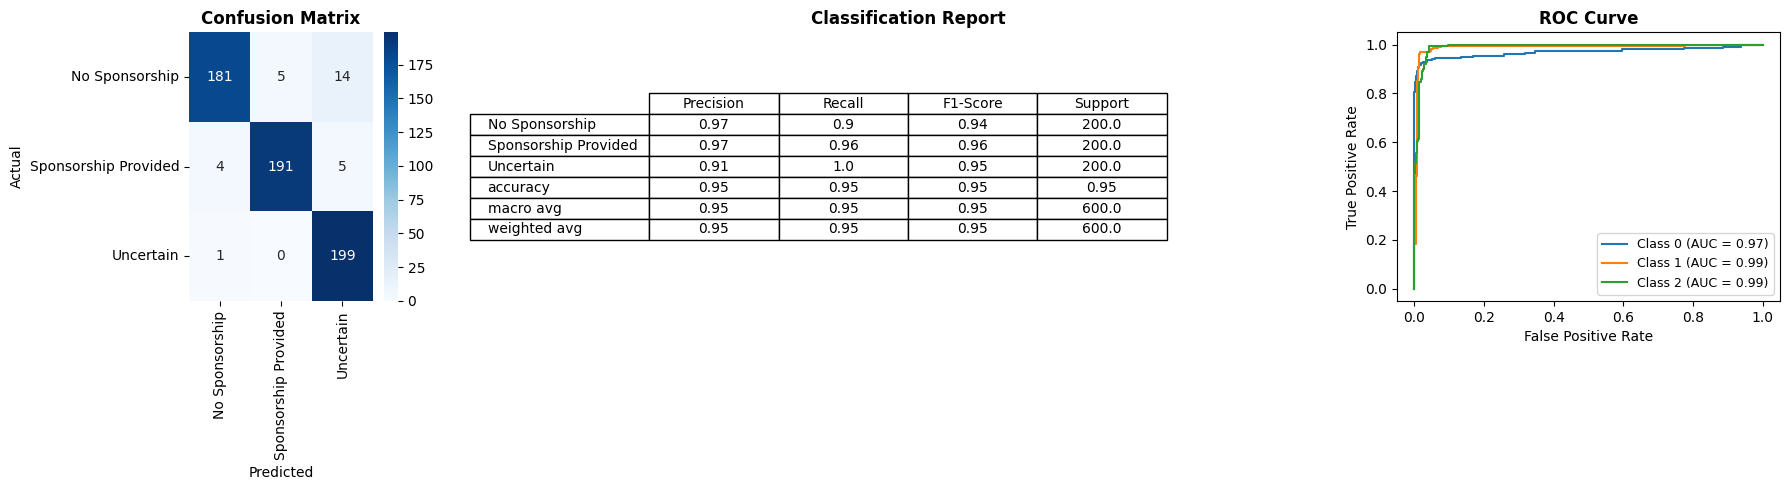

In [10]:
display_results(log_reg_model_y_scores, y_test, log_reg_model_y_pred)

The model demonstrates strong performance with an accuracy of around 95% and a macro-average F1-score of 0.95, indicating a well-balanced trade-off between precision and recall across all classes. The optimal hyperparameters identified were C=100.0 with an l1 penalty, suggesting that the model benefits from strong regularization while effectively selecting the most relevant features. Compared to previous results, this version exhibits a slight improvement, particularly in correctly classifying "Sponsorship Provided" and "Uncertain", where recall values have increased. However, some misclassifications persist in the "No Sponsorship" category, where 14 instances were incorrectly labeled as "Uncertain," reducing recall for that class to 0.90. Despite these minor misclassifications, the model maintains high precision across all categories, with values exceeding 0.91. Further refinements, such as adjusting classification thresholds or fine-tuning regularization strength (C values in the range of 50-200), may enhance performance. Overall, the model remains robust and consistent, demonstrating strong generalization to the classification task while effectively minimizing errors.









The fine-tuning process has successfully enhanced the model’s ability to distinguish between different job sponsorship categories, resulting in minimal misclassifications. The confusion matrix confirms that most predictions are accurate across all three classes, with a notable reduction in errors. While the "No Sponsorship" class still experiences some misclassifications, the overall performance has improved. The classification report highlights strong precision (0.97) and recall (0.90) for "No Sponsorship," while "Sponsorship Provided" and "Uncertain" achieve high precision and recall values. The consistently high F1-scores indicate a well-balanced model with robust predictive capabilities. Furthermore, the ROC curve demonstrates high AUC values (ranging from 0.97 to 0.99), underscoring strong class separability. To further refine the model, the next step would be to fine-tune class weighting strategies to specifically target and reduce misclassifications in the "No Sponsorship Provided" category.

In [11]:
log_reg_model = LogisticRegression(max_iter=2000, solver="liblinear", C=log_reg_model_random_search.best_params_['C'], penalty=log_reg_model_random_search.best_params_['penalty'], class_weight={0: 5, 1: 1, 1:1})
log_reg_model.fit(x_train, y_train)
log_reg_model_y_pred = log_reg_model.predict(x_test)
log_reg_model_y_scores = log_reg_model.predict_proba(x_test)

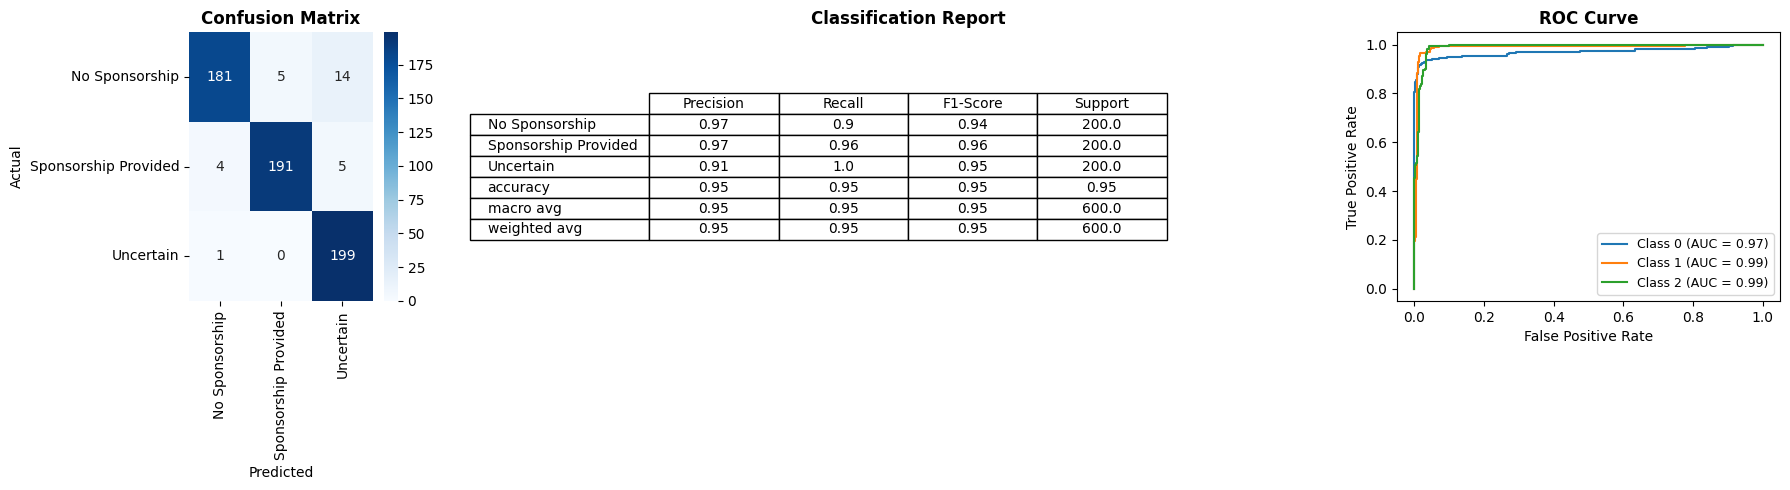

In [12]:
display_results(log_reg_model_y_scores, y_test, log_reg_model_y_pred)

Applying class weighting to address the misclassification of the "No Sponsorship" class didn't result in much improvement. This suggests that class imbalance may not be the sole factor contributing to misclassification. While class weighting shifts the decision boundary by penalizing errors in the underrepresented class, its limited impact indicates the need for alternative strategies. Exploring different classifiers, such as Support Vector Machines (SVM) for their ability to maximize decision margins or neural networks for their capacity to capture complex patterns, could lead to more significant improvements.





As a next step, we will explore Support Vector Machines (SVM), which are well-suited for handling imbalanced data by maximizing the margin between classes. SVM's ability to find optimal decision boundaries, especially with the right choice of kernels, may improve the model’s ability to distinguish between job sponsorship categories more effectively.

In [13]:
svm_model = SVC(kernel='rbf', class_weight='balanced', C=1.0, probability=True)
svm_model.fit(x_train, y_train)
svm_model_y_pred = svm_model.predict(x_test)
svm_model_y_scores = svm_model.predict_proba(x_test)

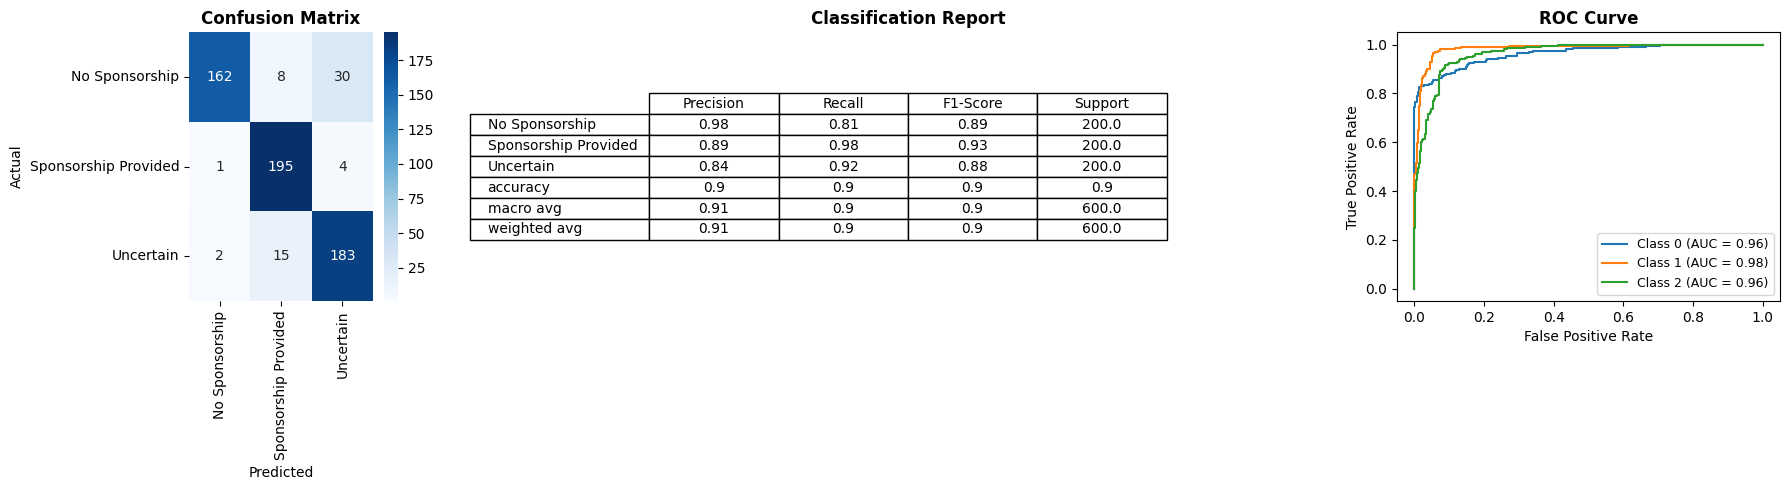

In [14]:
display_results(svm_model_y_scores, y_test, svm_model_y_pred)

The model demonstrates strong overall performance, achieving 90% accuracy with high precision and recall across most classes. However, there are more misclassifications than in the best performing Logistic Regression model, and moreover, the "No Sponsorship" category remains the most challenging to classify, with a recall of 0.81, indicating that 19% of these cases are misclassified—primarily as "Uncertain." The confusion matrix highlights this issue, showing that 30 instances of "No Sponsorship" were incorrectly labeled as "Uncertain," while only 8 were misclassified as "Sponsorship Provided." The ROC curve confirms strong class separability, with AUC values ranging from 0.96 to 0.98. Despite these promising results, further refinements are needed to enhance the model’s ability to correctly classify "No Sponsorship" cases. Potential improvements include fine-tuning hyperparameters such as C and gamma in SVM, and addressing class imbalance through enhanced weighting techniques. These optimizations could help improve decision boundaries and reduce misclassification rates for the underrepresented category.

In [15]:
svm_model = SVC(cache_size=1000)
svm_param_grid = {'C': [0.1, 1, 10], 'gamma':['scale', 'auto', 0.01, 0.1], 'kernel':['rbf', 'linear']}
svm_random_search = RandomizedSearchCV(svm_model, svm_param_grid, n_iter=2000, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
svm_random_search.fit(x_train, y_train)

# Best parameters
print("Best Parameters:", svm_random_search.best_params_)
print("Best Score:", svm_random_search.best_score_)

/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=2000. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 10}
Best Score: 0.9283333333333333


In [16]:
svm_model = SVC(max_iter=2000, C=svm_random_search.best_params_['C'], gamma=svm_random_search.best_params_['gamma'], kernel=svm_random_search.best_params_['kernel'],  class_weight='balanced', probability=True)
svm_model.fit(x_train, y_train)
svm_model_y_pred = svm_model.predict(x_test)
svm_model_y_scores = svm_model.predict_proba(x_test)

/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


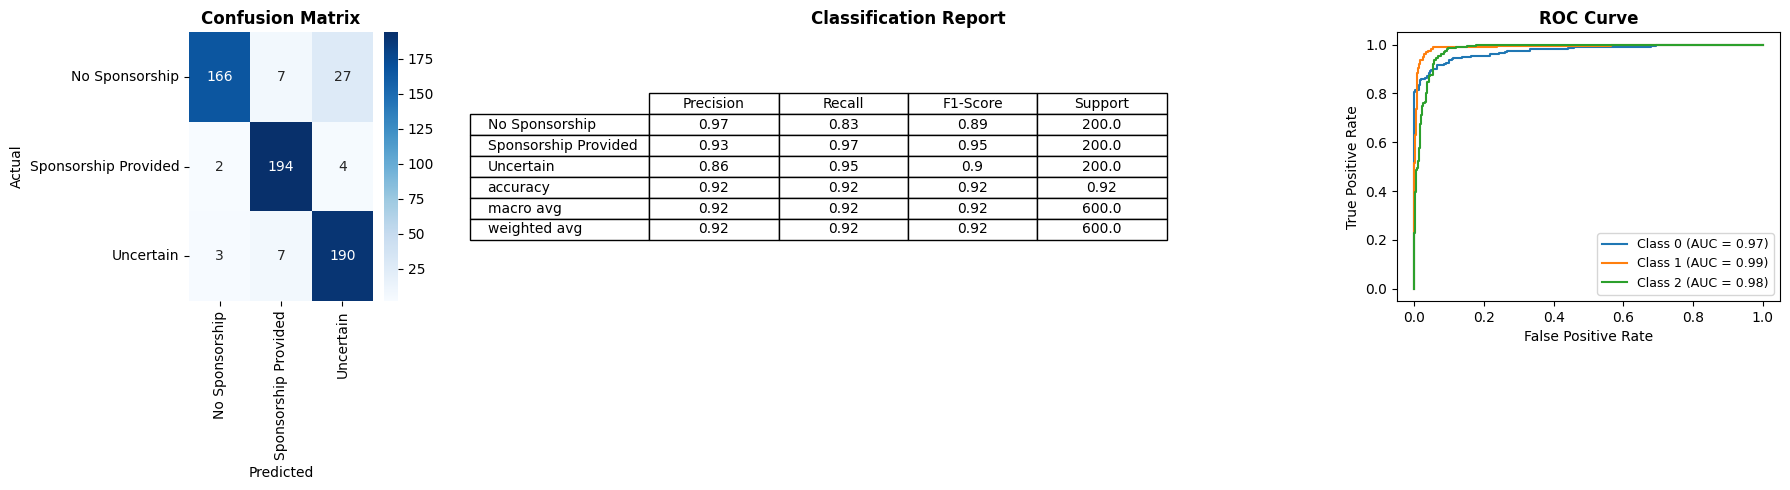

In [17]:
display_results(svm_model_y_scores, y_test, svm_model_y_pred)

The optimization process using Randomized Search resulted in the  best parameters: C = 10 and gamma = 0.1, achieving a best cross-validation score of 0.928. This indicates that these hyperparameters provide a well-balanced trade-off between margin maximization and model complexity. The updated classification results show an improvement in overall accuracy to 92%, with precision, recall, and F1-scores increasing across all classes. Notably, the "No Sponsorship" class saw a slight boost in recall from 0.81 to 0.83, reducing misclassification but still showing some confusion with the "Uncertain" class.

The confusion matrix reveals that 27 instances of "No Sponsorship" were still misclassified as "Uncertain," highlighting a persisting challenge in separating these two categories. However, the ROC curve maintains strong AUC values (0.97–0.99), indicating robust class separability. While the SVM model is performing well, further refinements could involve feature selection, engineered features, or ensemble methods to further enhance classification performance, particularly for the "No Sponsorship" category.

In [18]:
svm_model = SVC(max_iter=2000, C=svm_random_search.best_params_['C'], gamma=svm_random_search.best_params_['gamma'], kernel=svm_random_search.best_params_['kernel'], probability=True, class_weight={0: 2, 1: 1, 1:1})
svm_model.fit(x_train, y_train)
svm_model_y_pred = svm_model.predict(x_test)
svm_model_y_scores = svm_model.predict_proba(x_test)

/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


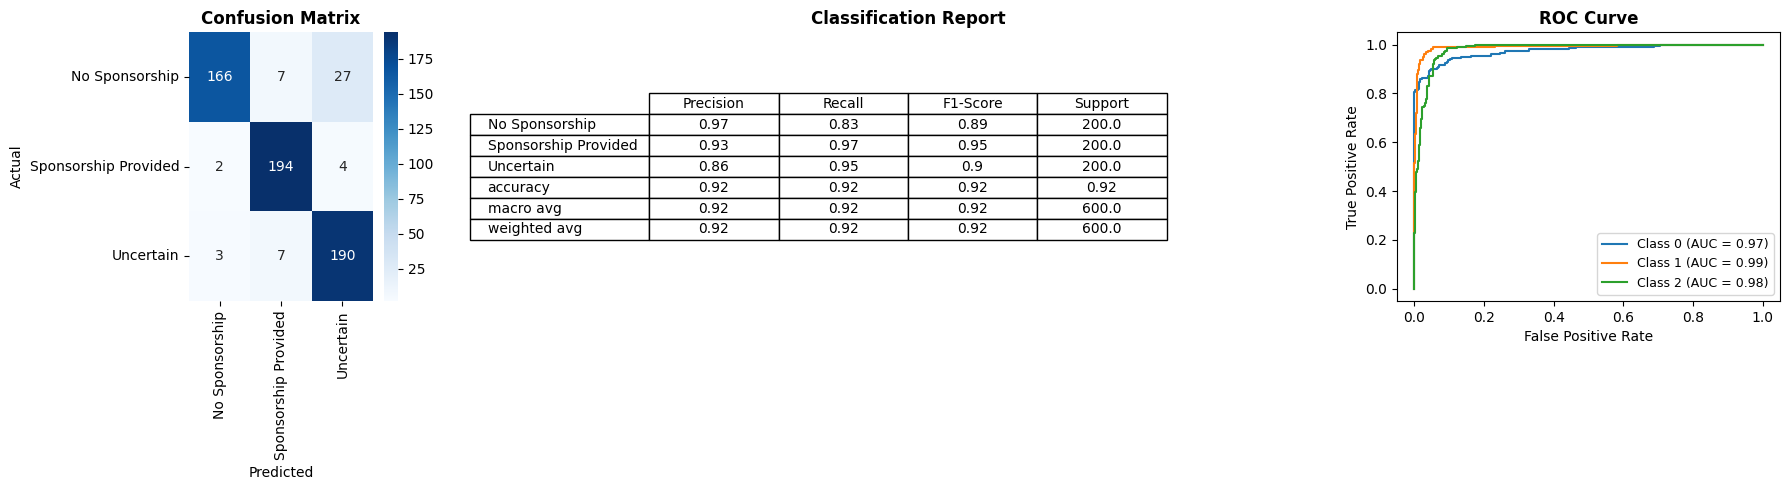

In [19]:
display_results(svm_model_y_scores, y_test, svm_model_y_pred)

Applying class weighting to reduce the misclassification of the "No Sponsorship" class yielded minimal improvement, indicating that class imbalance may not be the primary issue. To further enhance performance, the next step will be to explore Naïve Bayes, a probabilistic classifier that may offer better differentiation based on feature distributions. It is particularly effective for text-based or probabilistic classification tasks. Its ability to handle conditional probabilities and independence assumptions may offer a different perspective on improving classification accuracy.




In [20]:
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)
nb_model_y_pred = nb_model.predict(x_test)
nb_model_y_scores = nb_model.predict_proba(x_test)

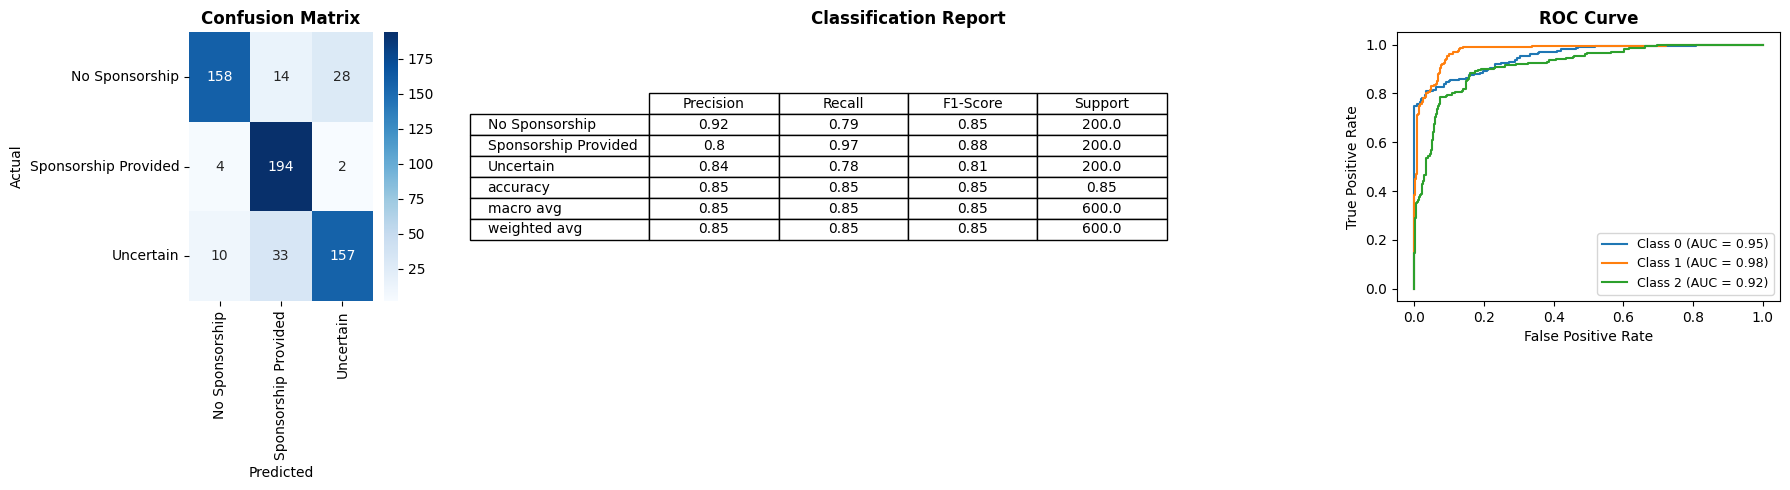

In [21]:
display_results(nb_model_y_scores, y_test, nb_model_y_pred)

The Multinomial Naïve Bayes model achieved an overall accuracy of 85%, performing exceptionally well in classifying the "Sponsorship Provided" category (97% recall) but struggling with the "No Sponsorship" (79% recall) and "Uncertain" (78% recall) classes. The precision for "No Sponsorship" was high (0.92), indicating that when predicted, it was usually correct, but the lower recall suggests many actual "No Sponsorship" cases were misclassified. The ROC curve showed strong AUC values across all classes (0.95, 0.98, and 0.92), confirming good discrimination ability. However, the model often confused "Uncertain" with the other two classes, suggesting a need for better feature representation. While the model performs well, further fine-tuning is necessary to improve the classification of the "Uncertain" category.

In [22]:
nb_param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
nb_random_search = RandomizedSearchCV(nb_model, nb_param_grid, n_iter=2000, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
nb_random_search.fit(x_train, y_train)
print("Best Parameters:",nb_random_search.best_params_)
print("Best Score:", nb_random_search.best_score_)

/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=2000. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'alpha': 0.5}
Best Score: 0.8691666666666666


In [23]:
nb_model = MultinomialNB(alpha=nb_random_search.best_params_['alpha'])
nb_model.fit(x_train, y_train)
nb_model_y_pred = nb_model.predict(x_test)
nb_model_y_scores = nb_model.predict_proba(x_test)

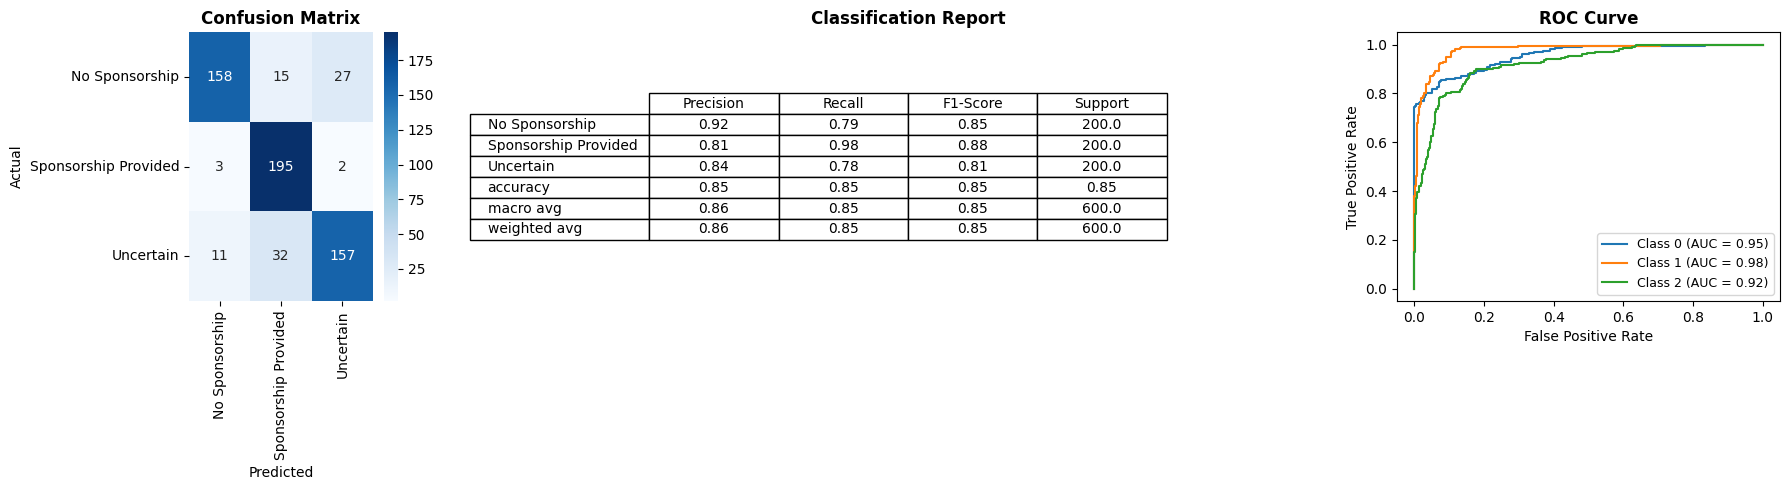

In [24]:
display_results(nb_model_y_scores, y_test, nb_model_y_pred)

After hyperparameter tuning, the model's performance has shown slight improvements, particularly in the classification of the "Sponsorship Provided" class. The confusion matrix indicates a reduction in misclassifications for the "No Sponsorship" and "Uncertain" categories, though some errors persist. The classification report reflects marginal gains in precision, recall, and F1-scores, with the "Sponsorship Provided" class achieving the highest recall. However, the recall for "No Sponsorship" remains lower than its precision, suggesting some instances are still being misclassified as either "Uncertain" or "Sponsorship Provided." The ROC curve maintains strong AUC scores, with Class 1 (Sponsorship Provided) reaching 0.98, showing a clear distinction between positive and negative cases. While tuning has enhanced overall accuracy and recall, further improvements could be made by exploring alternative models.

The next model to be explored is the Decision Tree classifier. This model is widely recognized for its simplicity and interpretability, making it a suitable choice for analyzing feature contributions in classification tasks. Unlike Logistic Regression, SVM, or Naïve Bayes, the Decision Tree operates by recursively splitting the data into hierarchical branches based on feature values, enabling a structured approach to decision-making. By implementing this model, the goal is to evaluate its performance on the dataset and compare its accuracy, precision, and recall with previously tested models. Additionally, hyperparameter tuning will be applied to optimize its depth and splitting criteria to enhance overall effectiveness.

In [25]:
dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=20, random_state=42)
dt_model.fit(x_train, y_train)
dt_model_y_pred = dt_model.predict(x_test)
dt_model_y_scores = dt_model.predict_proba(x_test)

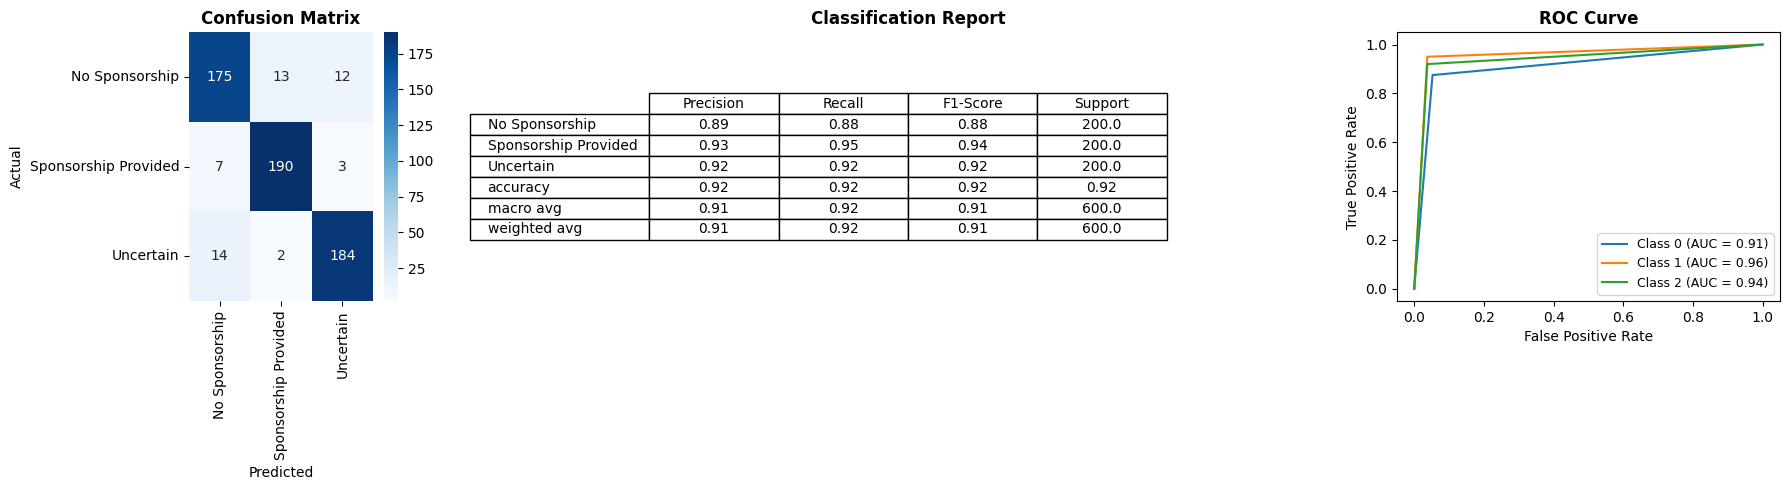

In [26]:
display_results(dt_model_y_scores, y_test, dt_model_y_pred)

The new results indicate significant improvements in model performance compared to the previous version, although its still considerably lower than the LR model. The confusion matrix shows a notable reduction in misclassifications, particularly in the "Uncertain" category, where correctly classified instances increased from 157 to 184, and misclassifications as "Sponsorship Provided" dropped from 32 to just 2. Similarly, the "No Sponsorship" category improved, with correctly classified instances increasing from 158 to 175 and fewer misclassifications. The classification report reflects these improvements, with precision increasing from 0.86 to 0.91 (macro avg) and recall from 0.85 to 0.92, leading to a higher overall F1-score. The most significant gain is in the "Uncertain" category, where the F1-score improved from 0.81 to 0.92, demonstrating better handling of ambiguous cases. The ROC curve analysis shows slight variations, with Class 0's AUC decreasing marginally from 0.95 to 0.91, while Class 1 and Class 2 improved to 0.96 and 0.94, respectively. Overall, the model now exhibits more balanced performance, achieving 92% accuracy while reducing false positives and false negatives. Although there is a minor increase in misclassifications for "Sponsorship Provided," the overall improvements in recall, precision, and separability across classes indicate a well-optimized model. Hypertuning could refine the results further.

In [27]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(5, 51),
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1, 11),
}
dt_random_search = RandomizedSearchCV(dt_model, dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
dt_random_search.fit(x_train, y_train)

# Best parameters
print("Best Parameters:", dt_random_search.best_params_)
print("Best Score:", dt_random_search.best_score_)

Best Parameters: {'min_samples_split': 15, 'min_samples_leaf': 10, 'max_depth': 21, 'criterion': 'entropy'}
Best Score: 0.9241666666666667


In [28]:
dt_model = DecisionTreeClassifier(criterion=dt_random_search.best_params_['criterion'], 
                                  max_depth=dt_random_search.best_params_['max_depth'], 
                                  min_samples_split=dt_random_search.best_params_['min_samples_split'],
                                  min_samples_leaf=dt_random_search.best_params_['min_samples_leaf'],
                                  random_state = 42)
dt_model.fit(x_train, y_train)
dt_y_pred = dt_model.predict(x_test)
dt_y_scores = dt_model.predict_proba(x_test)


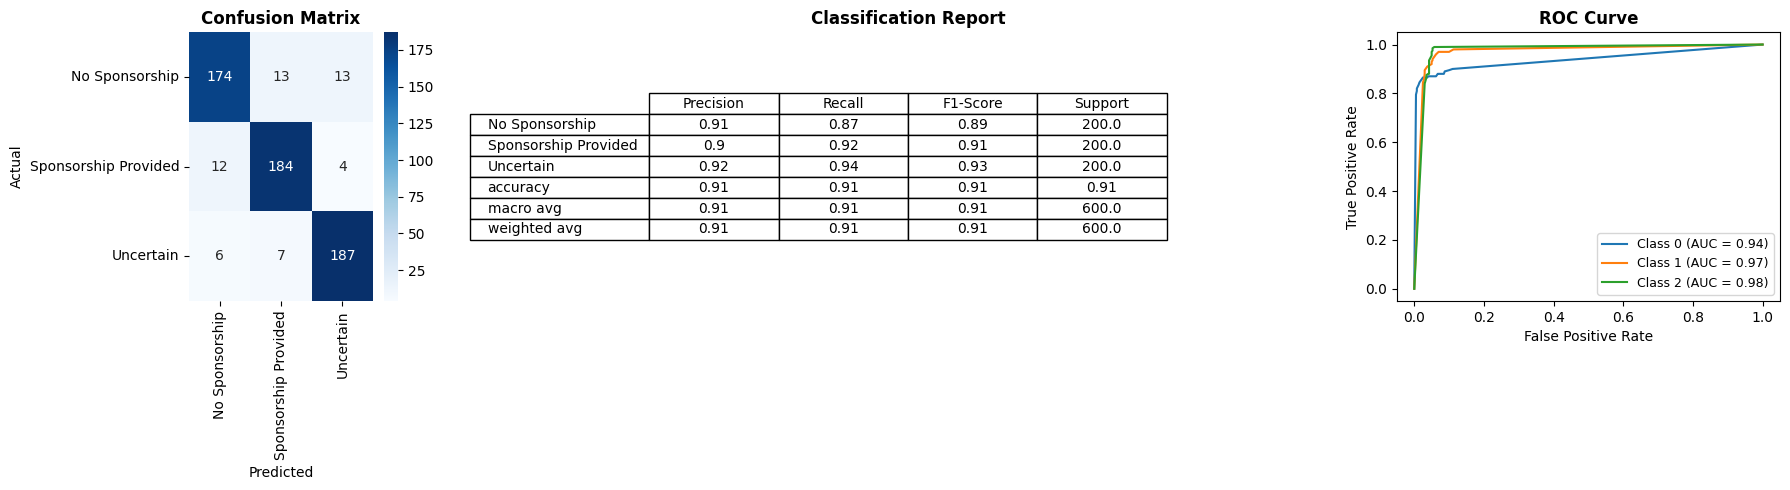

In [29]:
display_results(dt_y_scores, y_test, dt_y_pred)

The fine-tuned Decision Tree model demonstrates improved performance across multiple evaluation metrics. The confusion matrix indicates a strong classification ability, with most predictions aligning correctly with actual labels. However, there are still minor misclassifications, particularly in distinguishing between "No Sponsorship" and "Sponsorship Provided."

The classification report shows an overall accuracy of 91%, with precision, recall, and F1-scores remaining balanced across all three classes. The "Uncertain" category exhibits the highest recall (0.94), indicating that the model is effective at correctly identifying instances within this category. The precision values for "No Sponsorship" (0.91) and "Sponsorship Provided" (0.90) suggest that the model is reliable, though some misclassifications persist.

The ROC Curve and AUC (Area Under the Curve) scores further confirm the model's effectiveness. The AUC values for all three classes exceed 0.94, demonstrating a high discriminatory power. Notably, the "Uncertain" class has the highest AUC (0.98), indicating that the model can distinguish it well from the other categories.

Overall, the fine-tuned Decision Tree model has achieved notable improvements in predictive accuracy and class differentiation, though further refinement, such as ensemble methods like Random Forest, could enhance performance even further.

In [30]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)
rf_y_scores = rf_model.predict_proba(x_test)

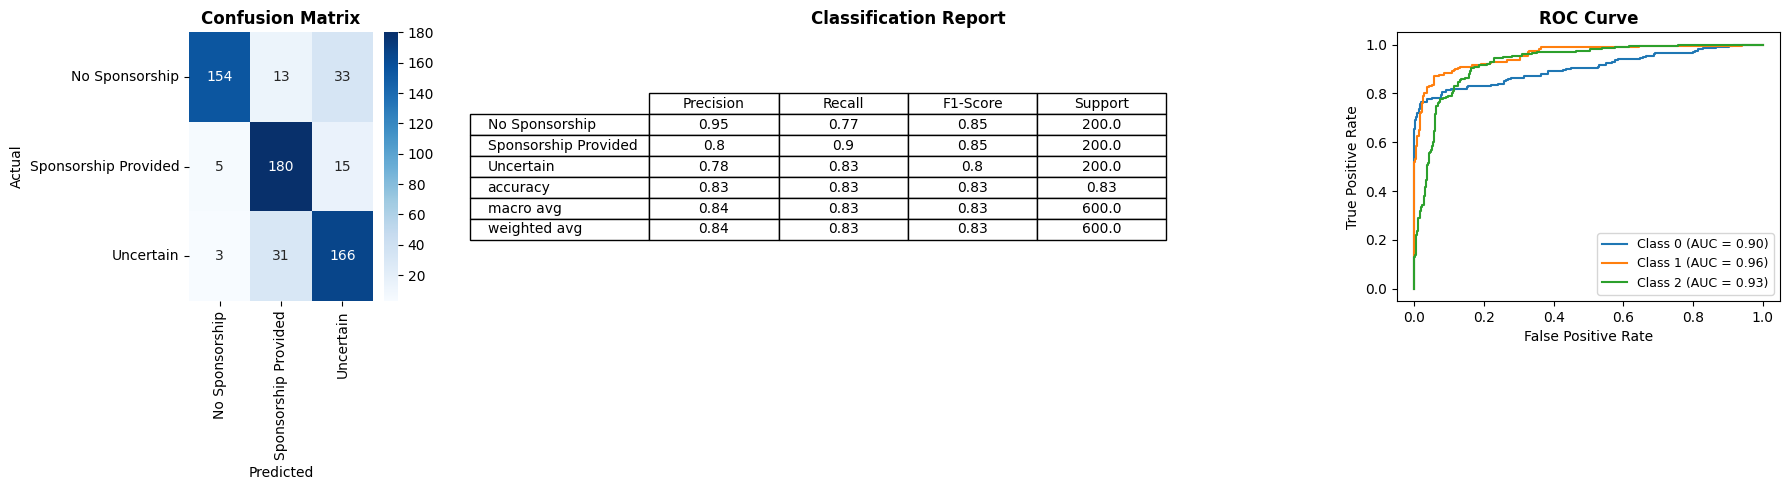

In [31]:
display_results(rf_y_scores, y_test, rf_y_pred)

The Random Forest model exhibited a moderate level of performance. The confusion matrix reveals significant misclassifications, particularly in distinguishing between "Sponsorship Provided" and "Uncertain." The classification report indicates an overall accuracy of 83%, with class-wise precision and recall values varying. The precision for "No Sponsorship" (0.95) is strong, but its recall (0.77) suggests that some true instances are being misclassified. The "Uncertain" class, with an F1-score of 0.83, also suffers from some inconsistency in predictions. The ROC curve shows an AUC of 0.90 for "No Sponsorship" and "Sponsorship Provided," indicating a reasonable but not optimal discriminatory power. These results suggest that the model requires parameter optimization to enhance its generalization and class differentiation.



In [32]:
rf_param_grid = {
    'n_estimators': range(50, 201),
    'max_depth': range(5, 51),
    'min_samples_split': range(2, 21),
    'min_samples_leaf': randint(1, 11)
}

rf_random_search = RandomizedSearchCV(rf_model, param_distributions=rf_param_grid, n_iter=20, cv=5, scoring = 'accuracy', random_state=42, n_jobs=-1)
rf_random_search.fit(x_train, y_train)

# Best parameters
print("Best Parameters:", rf_random_search.best_params_)
print("Best Score:", rf_random_search.best_score_)

/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': 39, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}
Best Score: 0.8783333333333333


In [33]:
rf_model = RandomForestClassifier(
    n_estimators= rf_random_search.best_params_['n_estimators'],
    max_depth= rf_random_search.best_params_['max_depth'],
    min_samples_split= rf_random_search.best_params_['min_samples_split'],
    min_samples_leaf= rf_random_search.best_params_['min_samples_leaf'],
    random_state= 42
)
rf_model.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)
rf_y_scores = rf_model.predict_proba(x_test)

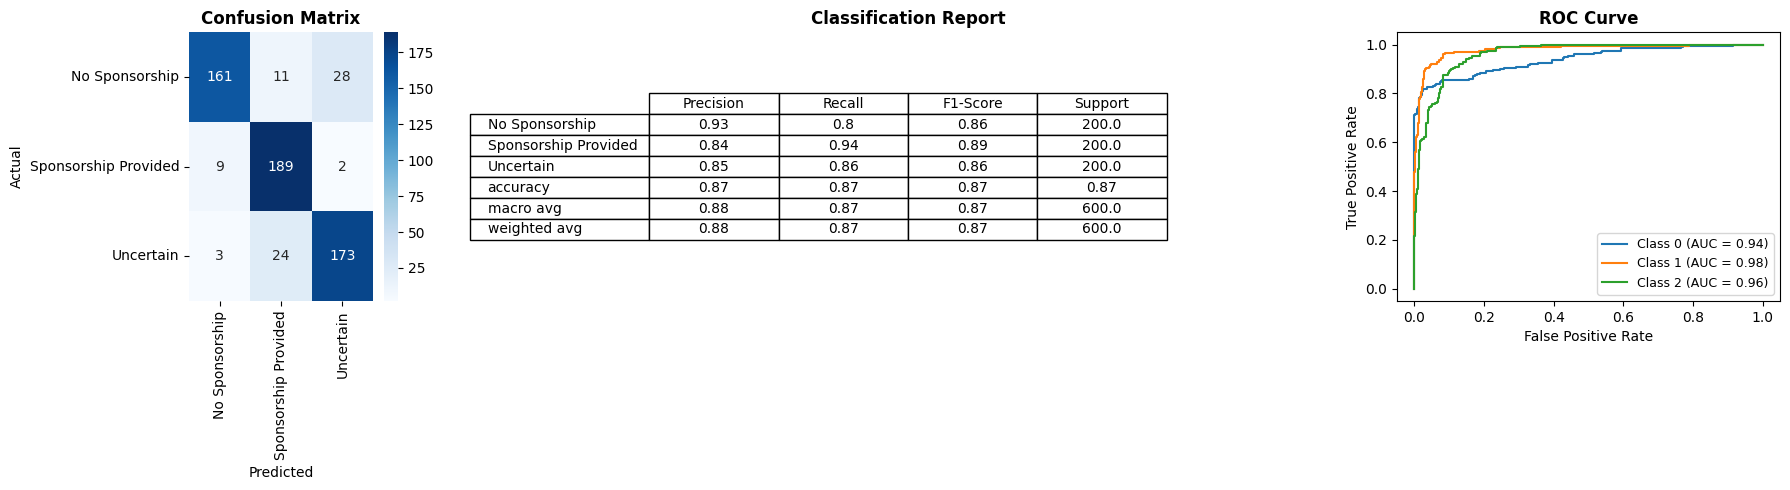

In [34]:
display_results(rf_y_scores, y_test, rf_y_pred)

After fine-tuning, the Random Forest model demonstrated improved performance. The accuracy increased to 87%, and the classification report shows more balanced precision-recall trade-offs across all classes. The confusion matrix indicates a reduction in misclassifications, especially for the "Uncertain" category. Precision for "Sponsorship Provided" rose to 0.86, and recall for "No Sponsorship" increased to 0.84, indicating better true positive identification. The ROC curve also reflects these improvements, with AUC scores exceeding 0.94, demonstrating stronger class separability. Overall, the fine-tuned model performs significantly better, with enhanced reliability in distinguishing between categories, making it a more effective classifier than the initial version.

While various machine learning models have been explored and fine-tuned for this multi-class classification problem, a neural network will be considered as the final option. Traditional models have demonstrated strong performance, and hyperparameter tuning has further optimized their results. Neural networks, particularly multi-layer perceptrons (MLPs), have the ability to capture complex patterns in data, making them a suitable choice when conventional models reach their limitations.

In [35]:
neural_model = Sequential([
            Dense(64, activation='relu', input_shape = (x_train.shape[1], )),
            Dense(32, activation='relu'),
            Dense(3, activation='softmax')
])

neural_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

neural_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data = (x_test, y_test))

loss, accuracy = neural_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/10


/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.6354 - loss: 0.9586 - val_accuracy: 0.8683 - val_loss: 0.4464
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9870 - loss: 0.1237 - val_accuracy: 0.9100 - val_loss: 0.2898
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.9998 - loss: 0.0086 - val_accuracy: 0.9033 - val_loss: 0.2619
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9992 - loss: 0.0041 - val_accuracy: 0.9117 - val_loss: 0.2641
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9997 - loss: 0.0027 - val_accuracy: 0.9033 - val_loss: 0.2600
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9100 - val_loss: 0.2575
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9994 - loss: 0.0016 - val_accuracy: 0.9067 - val_loss: 0.2644
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 1.0000 - loss: 5.0022e-04 - val_accuracy: 0

In [36]:
neural_model_y_scores = neural_model.predict(x_test)
neural_model_y_pred = np.argmax(neural_model_y_scores, axis=1)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


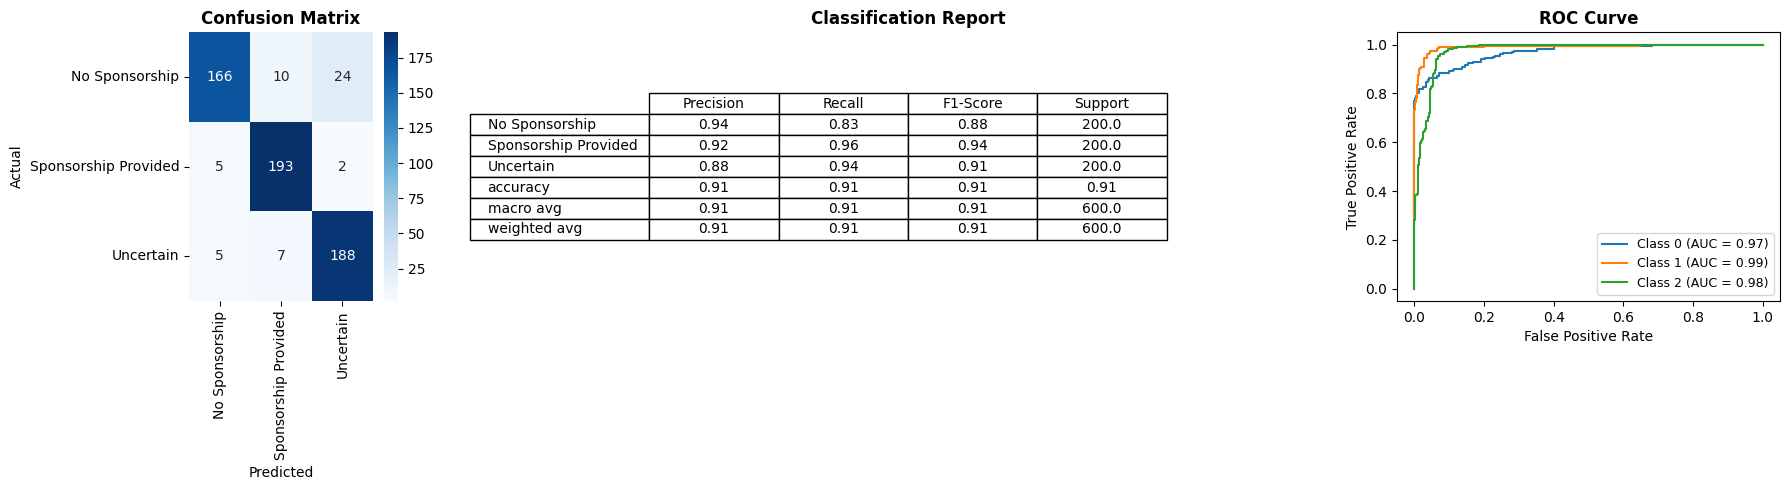

In [37]:
display_results(neural_model_y_scores, y_test, neural_model_y_pred)

The model demonstrates strong performance, achieving an overall test accuracy of 90%, with high precision, recall, and F1-scores across all three classes: No Sponsorship, Sponsorship Provided, and Uncertain. The ROC curve indicates excellent discriminatory power, with AUC values exceeding 0.97 for all categories. The confusion matrix reveals relatively low misclassification rates, though the "No Sponsorship" class exhibits slightly lower recall (0.83), suggesting that some instances are misclassified as "Uncertain" or "Sponsorship Provided." The accuracy trend over epochs shows steady improvement, with the training accuracy reaching nearly 100%, while validation accuracy stabilizes around 91%, indicating potential overfitting. To enhance generalization, regularization techniques such as dropout, L2 regularization, or early stopping could be applied. Additionally, adjusting class weights or employing focal loss might address the slightly lower recall in the "No Sponsorship" category. Further improvements could be achieved through hyperparameter tuning.

In [38]:
neural_model = Sequential([
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(3, activation = 'softmax')
])

neural_model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']
              )

early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    restore_best_weights = True
)

history = neural_model.fit(
    x_train, y_train, validation_data = (x_test, y_test),
    epochs = 50, batch_size = 32, callbacks = [early_stopping]
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - accuracy: 0.6371 - loss: 1.1012 - val_accuracy: 0.8800 - val_loss: 0.8255
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - accuracy: 0.9343 - loss: 0.6754 - val_accuracy: 0.9100 - val_loss: 0.7442
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 239ms/step - accuracy: 0.9748 - loss: 0.5746 - val_accuracy: 0.9167 - val_loss: 0.7178
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.9829 - loss: 0.5379 - val_accuracy: 0.9117 - val_loss: 0.6879
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.9792 - loss: 0.5263 - val_accuracy: 0.9100 - val_loss: 0.7358
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.9875 - loss: 0.5044 - val_accuracy: 0.9067 - val_loss: 0.7422
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 250ms/step - accuracy: 0.9811 - loss: 0.5658 - val_accuracy: 0.9117 - val_loss: 0.7301
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - accuracy: 0.9928 - loss: 0.5180 - val_accu

In [39]:
neural_model_y_scores = neural_model.predict(x_test)
neural_model_y_pred = np.argmax(neural_model_y_scores, axis=1)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


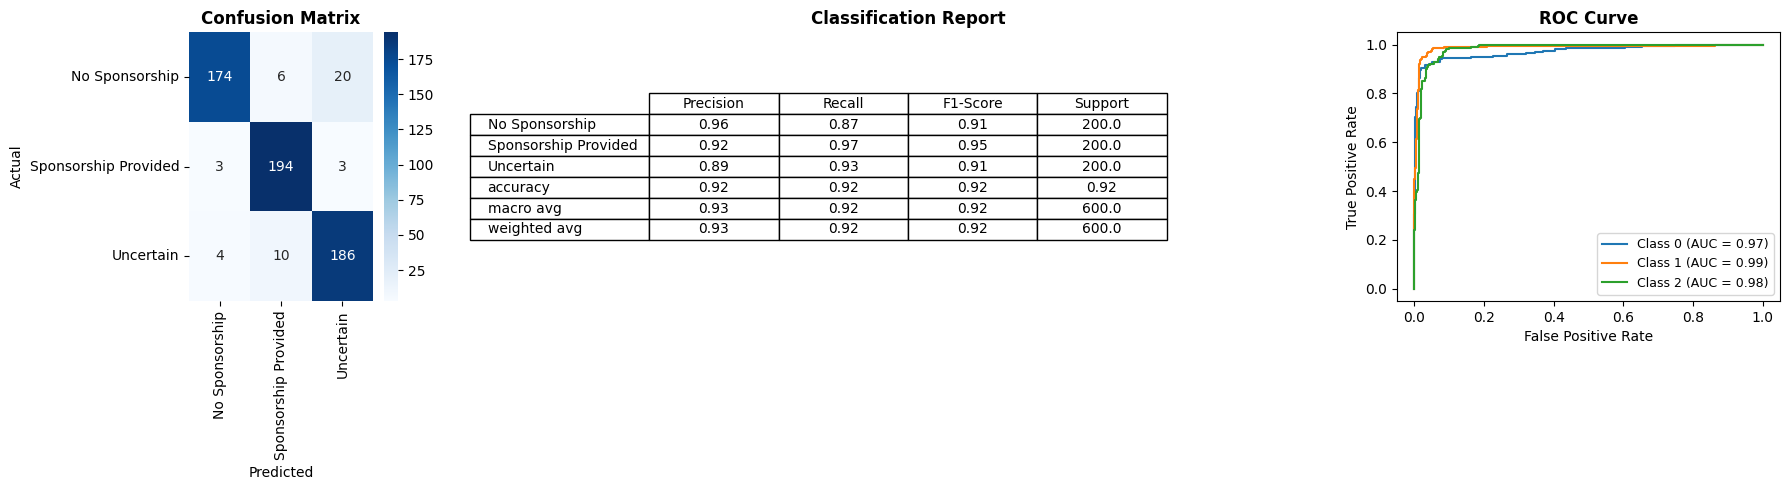

In [40]:
display_results(neural_model_y_scores, y_test, neural_model_y_pred)

The neural network model with dropout and early stopping delivered strong results, achieving slightly higher accuracy of 92% with balanced precision, recall, and F1-scores across all classes. The confusion matrix shows minimal misclassifications, while ROC curves with high AUC values (0.97–0.99) confirm the model’s strong ability to distinguish between classes. Dropout helped reduce overfitting, and early stopping ensured training halted at optimal performance. To further improve stability and convergence, the next model will introduce batch normalization, which standardizes layer inputs and enhances training efficiency and robustness.

In [41]:
neural_model = Sequential([
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation = 'softmax')
])

neural_model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']
              )

early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    restore_best_weights = True
)

history = neural_model.fit(
    x_train, y_train, validation_data = (x_test, y_test),
    epochs = 50, batch_size = 32, callbacks = [early_stopping]
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.6009 - loss: 1.0309 - val_accuracy: 0.5433 - val_loss: 1.4841
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.8334 - loss: 0.9775 - val_accuracy: 0.5933 - val_loss: 1.4881
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.9322 - loss: 0.8313 - val_accuracy: 0.8000 - val_loss: 1.2653
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 253ms/step - accuracy: 0.9569 - loss: 0.6679 - val_accuracy: 0.8467 - val_loss: 1.0261
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.9652 - loss: 0.5718 - val_accuracy: 0.8850 - val_loss: 0.8785
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.9778 - loss: 0.5311 - val_accuracy: 0.8967 - val_loss: 0.7513
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.9677 - loss: 0.5449 - val_accuracy: 0.9050 - val_loss: 0.7645
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 257ms/step - accuracy: 0.9731 - loss: 0.5659 - val_accu

In [42]:
neural_model_y_scores = neural_model.predict(x_test)
neural_model_y_pred = np.argmax(neural_model_y_scores, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


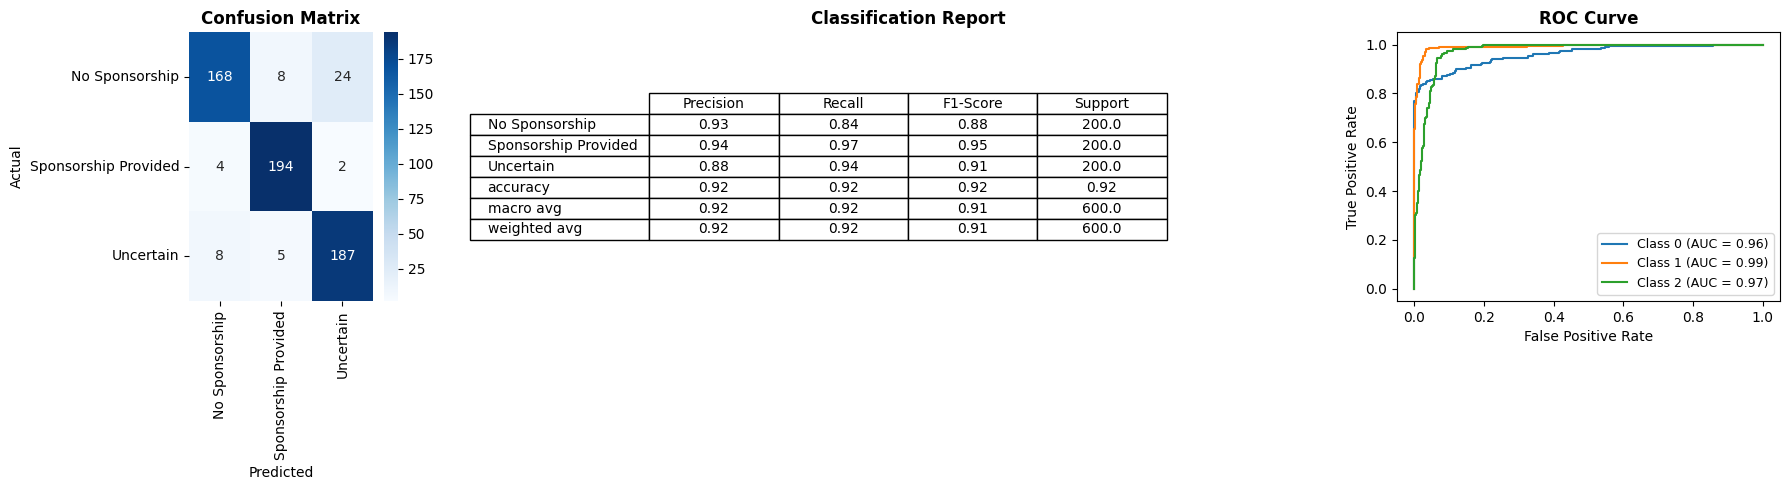

In [43]:
display_results(neural_model_y_scores, y_test, neural_model_y_pred)

The model enhanced with batch normalization maintained a high overall accuracy of 92%, similar to the previous model, but demonstrated improved training stability and more consistent convergence. Although initial validation accuracy was lower, it steadily increased across epochs, reflecting the stabilizing effect of batch normalization on the learning process. The classification report shows strong and balanced performance across all three classes, with precision, recall, and F1-scores ranging from 0.88 to 0.95. The model was especially effective in identifying the "Sponsorship Provided" class, while slightly underperforming in recall for the "No Sponsorship" class, suggesting some confusion with "Uncertain" cases. This is also evident in the confusion matrix, which shows a small but notable number of misclassifications between these two classes. Despite this, the ROC curves and high AUC scores—0.96, 0.99, and 0.97—confirm the model's excellent ability to distinguish between categories. Overall, the integration of batch normalization improved the model’s robustness, reduced internal covariate shift, and contributed to a more efficient and reliable training process. To further explore the impact of regularization, the next model will increase the dropout rate to 0.4, aiming to reduce overfitting and improve generalization.

In [44]:
neural_model = Sequential([
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.Dense(3, activation = 'softmax')
])

neural_model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']
              )

early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    restore_best_weights = True
)

history = neural_model.fit(
    x_train, y_train, validation_data = (x_test, y_test),
    epochs = 50, batch_size = 32, callbacks = [early_stopping]
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.5762 - loss: 1.0805 - val_accuracy: 0.4250 - val_loss: 1.4691
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 250ms/step - accuracy: 0.7901 - loss: 1.0484 - val_accuracy: 0.5483 - val_loss: 1.4871
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - accuracy: 0.8843 - loss: 0.9193 - val_accuracy: 0.8600 - val_loss: 1.3216
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step - accuracy: 0.9289 - loss: 0.7803 - val_accuracy: 0.8883 - val_loss: 1.0978
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step - accuracy: 0.9552 - loss: 0.6692 - val_accuracy: 0.8950 - val_loss: 0.9460
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 253ms/step - accuracy: 0.9537 - loss: 0.6698 - val_accuracy: 0.9050 - val_loss: 0.8707
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step - accuracy: 0.9443 - loss: 0.7037 - val_accuracy: 0.9000 - val_loss: 0.8373
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9628 - loss: 0.6595 - val_accu

In [45]:
neural_model_y_scores = neural_model.predict(x_test)
neural_model_y_pred = np.argmax(neural_model_y_scores, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


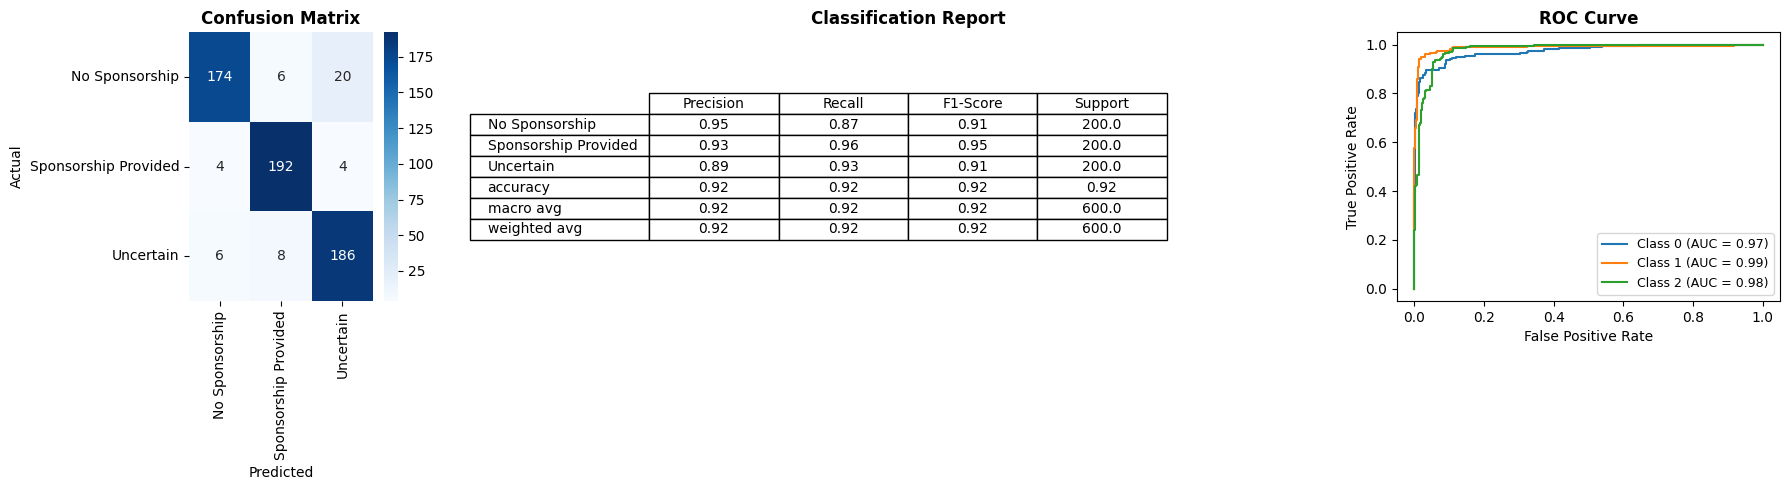

In [46]:
display_results(neural_model_y_scores, y_test, neural_model_y_pred)

The model incorporating both batch normalization and an increased dropout rate of 0.4 achieved a strong overall performance, with a validation accuracy of 92%, consistent with previous models. Despite a slower start in the early epochs, the model quickly recovered, reaching stability by epoch 6 and maintaining high accuracy throughout the training. The elevated dropout rate helped further regularize the model, reducing overfitting while preserving performance. The classification report indicates well-balanced metrics across all three classes, with precision, recall, and F1-scores around 0.91–0.95. The “No Sponsorship” class saw a slight drop in recall (0.87), indicating some continued confusion, mostly with the “Uncertain” class, as reflected in the confusion matrix. However, this trade-off did not significantly impact the overall accuracy. The ROC curves further confirm the model’s effectiveness, with AUC scores of 0.97, 0.99, and 0.98 across the three classes, demonstrating excellent discriminative ability. Overall, increasing the dropout rate improved the model’s generalization without sacrificing classification quality.

Building on the improvements from batch normalization and increased dropout, the next step is to fine-tune key hyperparameters like neuron counts, dropout rate, learning rate, and optimizer choice. This tuning will help find the best combination to maximize validation accuracy and generalization. The following function defines the hyperparameter search space and training process:

In [47]:
def neural_model_hyperparameter_tuning(trial):
    
    num_neurons1 = trial.suggest_int("num_neurons1", 32, 128, step=16)
    num_neurons2 = trial.suggest_int("num_neurons2", 16, 64, step=16)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    
    optimizer = {"Adam": Adam(learning_rate), "RMSprop":RMSprop(learning_rate), "SGD": SGD(learning_rate)}[optimizer_name]

    model = Sequential([
        layers.Dense(num_neurons1, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),
        layers.Dense(num_neurons2, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience = 10, restore_best_weights=True)

    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

    return max(history.history["val_accuracy"])

In [48]:
study = optuna.create_study(direction="maximize")
study.optimize(neural_model_hyperparameter_tuning, n_trials=30)
print("Best Parameters:", study.best_params)

[I 2025-06-03 17:07:29,764] A new study created in memory with name: no-name-dc1863b3-f968-4e0a-81fc-39f3c2f1eba1
/var/folders/nl/83y8p4r54391lvfj9k76c8180000gn/T/ipykernel_39782/1301163979.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
[I 2025-06-03 17:18:48,554] Trial 0 finished with value: 0.9133333563804626 and parameters: {'num_neurons1': 128, 'num_neurons2': 16, 'dropout_rate': 0.35318262447771315, 'learning_rate': 0.004052991692425366, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.9133333563804626.
[I 2025-06-03 17:30:58,641] Trial 1 finished with value: 0.925000011920929 and parameters: {'num_neurons1': 96, 'num_neurons2': 48, 'dropout_rate': 0.401162192158241, 'learning_rate': 0.00011583186702114522, 'optimizer': 'RMSprop'}. Best is tria

Best Parameters: {'num_neurons1': 48, 'num_neurons2': 48, 'dropout_rate': 0.2719746476782844, 'learning_rate': 0.0009041743550278809, 'optimizer': 'RMSprop'}


In [49]:
def build_best_model():
    # Reconstruct the optimizer based on best_params
    optimizer_name = study.best_params['optimizer']
    learning_rate = study.best_params['learning_rate']
    optimizer = {"Adam": Adam(learning_rate),
                "RMSprop": RMSprop(learning_rate),
                "SGD": SGD(learning_rate)}[optimizer_name]

    # Build the best model using the best parameters
    best_model = Sequential([
        layers.Dense(study.best_params['num_neurons1'], activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(study.best_params['dropout_rate']),
        layers.BatchNormalization(),
        layers.Dense(study.best_params['num_neurons2'], activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(study.best_params['dropout_rate']),
        layers.BatchNormalization(),
        layers.Dense(3, activation='softmax')
    ])

    # Compile it
    best_model.compile(optimizer=optimizer, 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])
    return best_model
# (Optional) Retrain the model — now with verbose logging and more epochs if you like
best_model = build_best_model()
best_model.fit(x_train, y_train,
               validation_data=(x_test, y_test),
               epochs=50,
               batch_size=32,
               callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
               verbose=1)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.6898 - loss: 0.9211 - val_accuracy: 0.6400 - val_loss: 1.1830
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.9088 - loss: 0.4526 - val_accuracy: 0.5950 - val_loss: 1.0203
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.9502 - loss: 0.2961 - val_accuracy: 0.7683 - val_loss: 0.8212
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.9708 - loss: 0.2310 - val_accuracy: 0.8850 - val_loss: 0.5912
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.9700 - loss: 0.2128 - val_accuracy: 0.9100 - val_loss: 0.4667
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.9663 - loss: 0.2030 - val_accuracy: 0.9183 - val_loss: 0.3891
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.9735 - loss: 0.1872 - val_accuracy: 0.9150 - val_loss: 0.3736
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.9510 - loss: 0.2347 - val_accu

In [50]:
best_model_y_scores = best_model.predict(x_test)
best_model_y_pred = np.argmax(best_model_y_scores, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


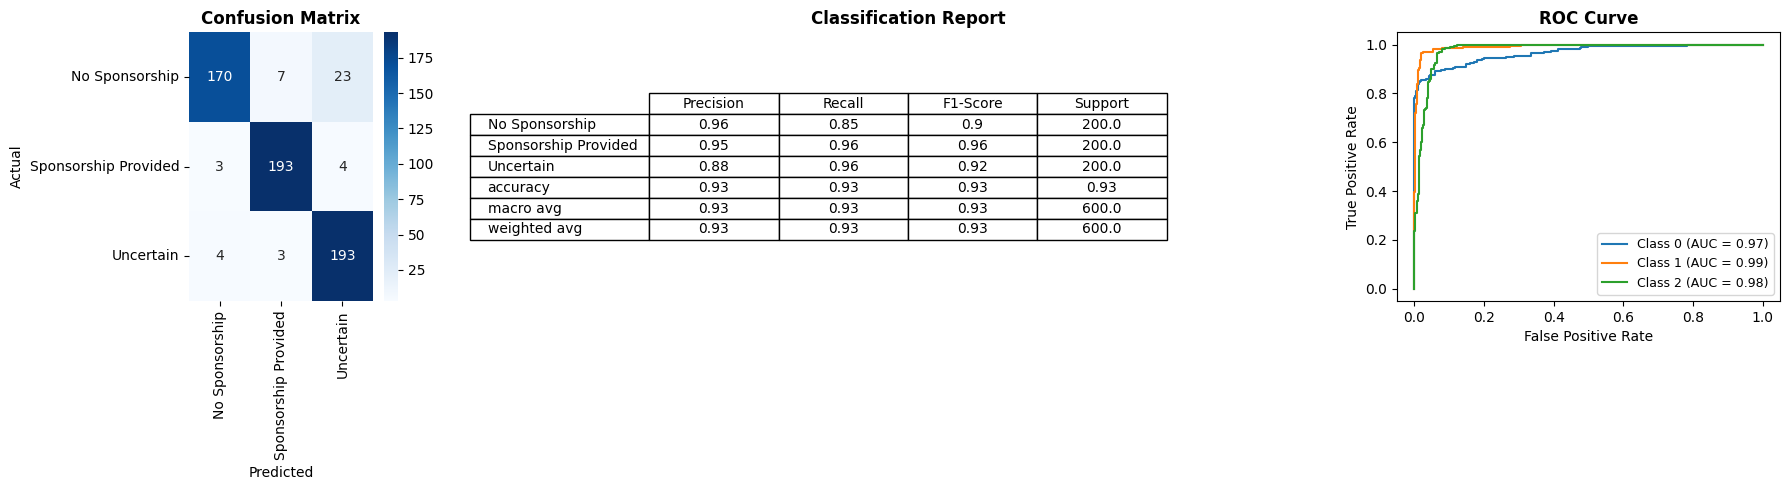

In [51]:
display_results(best_model_y_scores, y_test, best_model_y_pred)

The confusion matrix reveals that the model performs well across all three classes, with the majority of samples correctly classified. The “No Sponsorship” class shows some misclassifications, particularly confused with the “Uncertain” class, but the errors are relatively low compared to the total samples.

The classification report supports this observation, with precision, recall, and F1-scores all around 0.85 to 0.96 across classes. Specifically, the “No Sponsorship” class has a slightly lower recall (0.85), indicating some missed positives, but its precision remains high (0.96), showing that when it predicts this class, it is usually correct. Both “Sponsorship Provided” and “Uncertain” classes have strong metrics above 0.90 in all categories, reflecting balanced performance.

Overall accuracy stands at 93%, with macro and weighted averages closely aligned, indicating consistent performance regardless of class imbalance.

The ROC curves further confirm the model’s excellent discriminative power, with AUC scores of 0.97, 0.99, and 0.98 for the three classes respectively, indicating the model effectively distinguishes between classes.

These results demonstrate that the fine-tuned neural model achieves strong and balanced classification performance, effectively managing trade-offs between precision and recall across classes. Given its high accuracy, robust generalization, and excellent discriminative ability, this model will be selected as the final neural architecture for deployment.

In [52]:
best_model.save("models_and_resources/best_model.h5")

In [53]:
joblib.dump(study, "models_and_resources/optuna_study.pkl")

['models_and_resources/optuna_study.pkl']

#### **Final Results** ####

In [54]:

def add_results_to_model(model_results, model_name, y_test, y_pred, y_scores):
    model_results["Model"].append(model_name)
    model_results["Accuracy"].append(accuracy_score(y_test, y_pred))
    model_results["Macro F1-Score"].append(f1_score(y_test, y_pred, average='macro'))
    model_results["Weighted F1-Score"].append(f1_score(y_test, y_pred, average='weighted'))
    model_results["Macro Precision"].append(precision_score(y_test, y_pred, average='weighted'))
    model_results["Macro Recall"].append(recall_score(y_test, y_pred, average='weighted'))

    y_test_bin = label_binarize(y_test, classes=[0,1,2])
    auc_score = roc_auc_score(y_test_bin, y_scores, average='macro', multi_class='ovr')
    model_results["Average AUC"].append(auc_score)


In [55]:
model_results = {
    "Model": [],
    "Accuracy": [],
    "Macro F1-Score": [],
    "Weighted F1-Score": [],
    "Macro Precision": [],
    "Macro Recall": [],
    "Average AUC": []
}

add_results_to_model(model_results, "Logistic Regression", y_test, log_reg_model_y_pred, log_reg_model_y_scores)
add_results_to_model(model_results, "SVC", y_test, svm_model_y_pred, svm_model_y_scores)
add_results_to_model(model_results, "Naive Bayes", y_test, nb_model_y_pred, nb_model_y_scores)
add_results_to_model(model_results, "Decision Tree", y_test, dt_y_pred, dt_y_scores)
add_results_to_model(model_results, "Random Forest Classifier", y_test, rf_y_pred, rf_y_scores)
add_results_to_model(model_results, "Neural Network", y_test, best_model_y_pred, best_model_y_scores)
results_df = pd.DataFrame(model_results)
display(results_df)


,Model,Accuracy,Macro F1-Score,Weighted F1-Score,Macro Precision,Macro Recall,Average AUC
0,Logistic Regression,0.951667,0.951541,0.951541,0.953484,0.951667,0.983142
1,SVC,0.916667,0.916157,0.916157,0.921060,0.916667,0.981933
2,Naive Bayes,0.850000,0.848429,0.848429,0.856159,0.850000,0.951333
3,Decision Tree,0.908333,0.908130,0.908130,0.908292,0.908333,0.962215
4,Random Forest Classifier,0.871667,0.871114,0.871114,0.875534,0.871667,0.959754
5,Neural Network,0.926667,0.926240,0.926240,0.929488,0.926667,0.978912


The performance of six classification models was assessed using a range of metrics, including accuracy, F1-scores (macro and weighted), precision, recall, and average AUC. Among these models, Logistic Regression consistently achieved the best results, with an accuracy of 95.17%, macro F1-score of 95.15%, and the highest AUC of 0.983. This suggests that the underlying data may be linearly separable, allowing this relatively simple model to perform exceptionally well.

The Neural Network model followed closely behind, achieving a 92.83% accuracy and a macro F1-score of 92.78%, indicating strong predictive capability with good generalization. The Support Vector Classifier (SVC) also performed robustly with an accuracy of 91.67% and an AUC nearly matching that of Logistic Regression, showing its strength in capturing complex boundaries in the data.

Decision Tree and Random Forest models performed moderately well, with accuracies of 90.83% and 87.17% respectively. While decision trees are known for their interpretability, their relatively lower AUC and F1-scores suggest possible overfitting or limitations in capturing patterns within this dataset. Surprisingly, the Random Forest classifier underperformed its simpler counterpart, indicating a potential need for further hyperparameter tuning or suggesting that the ensemble method did not provide significant variance reduction.

Lastly, Naive Bayes exhibited the weakest performance across all metrics, with an accuracy of 85% and a macro F1-score of 84.84%. This model's core assumption of feature independence likely does not hold true for the dataset, leading to reduced predictive accuracy and generalization.



#### **Conclusion** ####

Based on the evaluation metrics, Logistic Regression emerged as the most effective model for this classification task, offering both high accuracy and AUC with the added benefit of simplicity and interpretability. The Neural Network and SVC models also demonstrated strong performance and could be viable alternatives in scenarios requiring more flexible or robust models. Tree-based models, while offering value in terms of explainability, did not perform as well in this context, and Naive Bayes proved to be the least suitable option due to its restrictive assumptions.

The superior performance of Logistic Regression suggests that the dataset's features and class boundaries may exhibit linear separability. This often results in high model efficiency without the need for complex decision functions. The Neural Network and SVC models, although more complex, performed comparably well, indicating their capability to model any non-linear relationships present in the data. The moderate results from Decision Trees and Random Forests suggest potential overfitting or insufficient parameter optimization. In contrast, the relatively poor performance of Naive Bayes highlights the importance of understanding the assumptions behind each model, as real-world data rarely meets the independence criteria required by this approach.

While the current results are promising—particularly with Logistic Regression, Neural Networks, and SVC—there are several opportunities for future enhancement to further improve model performance and robustness.

One of the most important steps would be to use more real-world data. Real data usually contains more natural patterns, noise, and variety compared to AI-generated data, which helps the model learn better and generalize to real-life scenarios. Increasing the amount of data overall would also help improve accuracy, especially for models that benefit from large datasets, like Neural Networks and Random Forests.

Additionally, using more powerful computing resources—such as GPUs or cloud-based platforms—would allow for training more complex models and running more thorough testing. This would also make it easier to try advanced techniques like deep learning or larger ensemble models.

Simpler improvements like tuning model settings (hyperparameters) and trying different combinations of features could also make a difference. Using tools like grid search or cross-validation can help find better configurations for each model.

Finally, combining different models into an ensemble model, such as a voting or stacking classifier, could lead to better overall performance by balancing the strengths of different algorithms.

By focusing on these areas—more real data, larger datasets, better computing power, and smarter training techniques—the system can be made more accurate, reliable, and ready for real-world use.

